In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

# initialize parameters
start_date = datetime(2020, 1, 1)
end_date = datetime(2023, 6, 16)
  
# get the data
df = yf.download('AAPL', start = start_date,
                   end = end_date)
df['Date'] = pd.to_datetime(df.index, format='%Y-%m-%d')
df = df.reset_index(drop = True)

[*********************100%***********************]  1 of 1 completed


Epoch 1/10
22/22 [==============================] - 3s 9ms/step - loss: 0.0821
Epoch 2/10
22/22 [==============================] - 0s 9ms/step - loss: 0.0080
Epoch 3/10
22/22 [==============================] - 0s 10ms/step - loss: 0.0028
Epoch 4/10
22/22 [==============================] - 0s 9ms/step - loss: 0.0019
Epoch 5/10
22/22 [==============================] - 0s 9ms/step - loss: 0.0016
Epoch 6/10
22/22 [==============================] - 0s 13ms/step - loss: 0.0016
Epoch 7/10
22/22 [==============================] - 0s 9ms/step - loss: 0.0017
Epoch 8/10
22/22 [==============================] - 0s 9ms/step - loss: 0.0016
Epoch 9/10
22/22 [==============================] - 0s 9ms/step - loss: 0.0017
Epoch 10/10
6/6 [==============================] - 1s 4ms/step
Mean Squared Error (MSE) on test set: 23631.781506425483


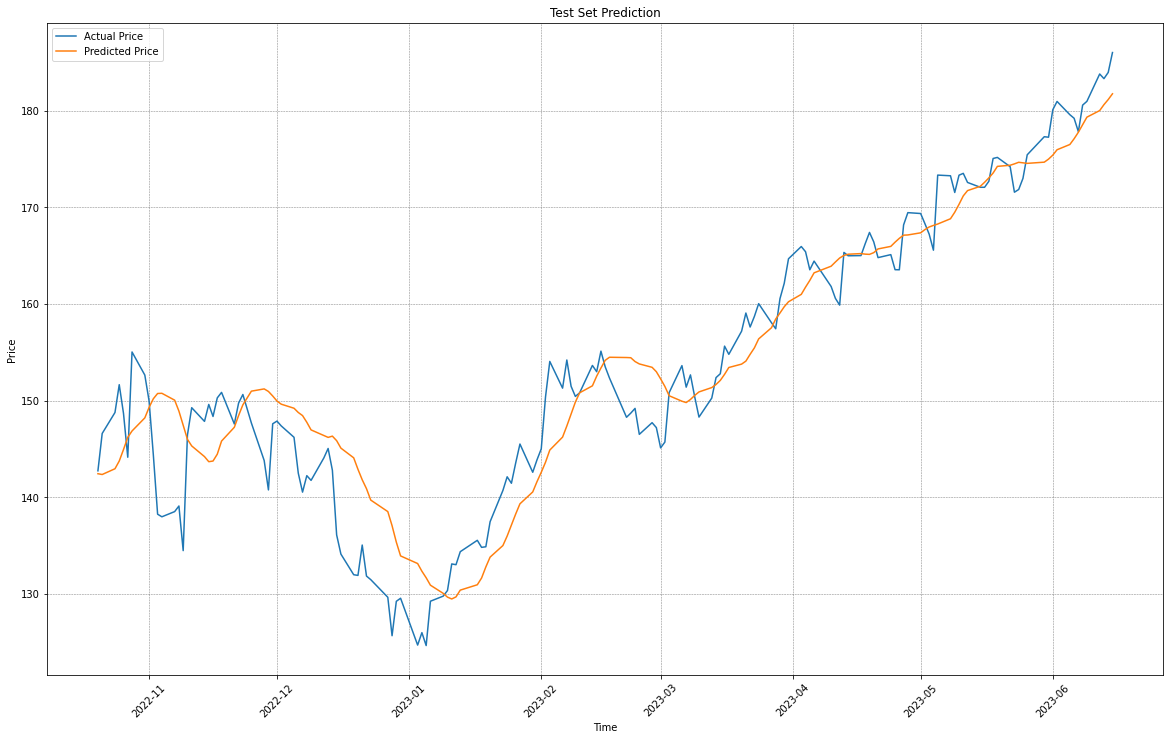

In [2]:
# Preprocess the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df['Adj Close'].values.reshape(-1, 1))

# Split the data into training and test sets
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Define the window size
window_size = 10

# Create input features and labels for training set
X_train, y_train = [], []
for i in range(window_size, len(train_data)):
    X_train.append(train_data[i - window_size:i, 0])
    y_train.append(train_data[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshape input features for LSTM [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32)

# Create input features for test set
X_test, y_test = [], []
for i in range(window_size, len(test_data)):
    X_test.append(test_data[i - window_size:i, 0])
    y_test.append(test_data[i, 0])
X_test, y_test = np.array(X_test), np.array(y_test)

# Reshape input features for LSTM [samples, time steps, features]
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Predict using the trained model on test set
predicted_price = model.predict(X_test)
predicted_price = scaler.inverse_transform(predicted_price)

# Calculate Mean Squared Error (MSE) on test set
mse = mean_squared_error(y_test, predicted_price)
print('Mean Squared Error (MSE) on test set:', mse)

test_date = df['Date'].values[train_size + window_size:]
# Plot the actual and predicted prices
plt.figure(figsize=(20, 12))
plt.grid(True, linestyle='--', linewidth=0.5, color='gray')
plt.plot(test_date,df['Adj Close'].values[train_size + window_size:], label='Actual Price')
plt.plot(test_date,predicted_price, label='Predicted Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Test Set Prediction')
plt.legend()
plt.xticks(rotation = 45)
plt.show()

1/1 [==============================] - 0s 21ms/step
Date: 2023-06-16T00:00:00.000000000 Predicted Price: 182.25455
Date: 2023-06-17T00:00:00.000000000 Predicted Price: 182.62354
Date: 2023-06-18T00:00:00.000000000 Predicted Price: 183.05466
Date: 2023-06-19T00:00:00.000000000 Predicted Price: 183.47363
Date: 2023-06-20T00:00:00.000000000 Predicted Price: 183.96292


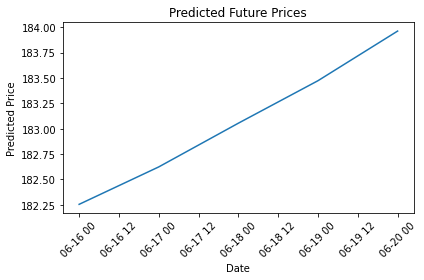

In [3]:
# Prepare the input data for prediction (e.g., predicting the next 5 days)
recent_data = df['Adj Close'].values[-window_size:]  # Take the most recent 'window_size' number of data points
scaled_recent_data = scaler.transform(recent_data.reshape(-1, 1))  # Scale the data

# Reshape input data for prediction [samples, time steps, features]
X_pred = np.reshape(scaled_recent_data, (1, window_size, 1))

# Predict future prices using the trained model
future_prices = []
num_future_days = 5  # Number of future days to predict
for _ in range(num_future_days):
    predicted_scaled_price = model.predict(X_pred)
    predicted_price = scaler.inverse_transform(predicted_scaled_price)
    future_prices.append(predicted_price[0, 0])
    
    # Update input data for the next prediction
    scaled_recent_data = np.append(scaled_recent_data[1:], predicted_scaled_price)
    X_pred = np.reshape(scaled_recent_data, (1, window_size, 1))

# Generate future dates for prediction
last_date = df['Date'].values[-1]  # Get the last date in the original dataset
future_dates = [last_date + np.timedelta64(i, 'D') for i in range(1, num_future_days + 1)]  # Predict for the next 5 days

# Print the predicted future prices with corresponding dates
for date, price in zip(future_dates, future_prices):
    print('Date:', date, 'Predicted Price:', price)
    
plt.plot(future_dates, future_prices)
plt.xlabel('Date')
plt.ylabel('Predicted Price')
plt.title('Predicted Future Prices')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()